Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
import hashlib

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
#загружаем данные за 2 - 8 декабря для 0 - 3-й экспериментальных групп
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125


In [5]:
#рассчитаем вначале p-value гипотез о разноси ctr 0 и 3-ей группы, а также 1 и 2-й. 
#Воспользуемся бакетным преобразованием.
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [6]:
df['hash_group'] = df.user_id.apply(ab_split)

In [7]:
df.head()

,exp_group,user_id,likes,views,ctr,hash_group
0,3,115383,9,30,0.300000,11
1,1,18392,7,32,0.218750,1
2,3,123580,13,48,0.270833,22
3,2,131473,14,134,0.104478,38
4,2,32420,26,128,0.203125,0


In [8]:
#сгруппируем пользователей по корзинам
df5 = df.groupby(['hash_group','exp_group'], as_index=False).agg({'likes' : 'sum', 'views' : 'sum'})
df5['b_ctr'] =  df5['likes']/df5['views']
df5.head()

,hash_group,exp_group,likes,views,b_ctr
0,0,0,2708,13183,0.205416
1,0,1,2993,13872,0.215758
2,0,2,2399,11979,0.200267
3,0,3,2902,13440,0.215923
4,1,0,2926,14309,0.204487


<AxesSubplot:xlabel='b_ctr', ylabel='Count'>

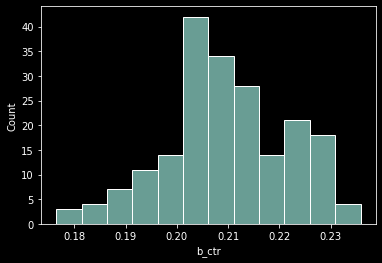

In [9]:
sns.histplot(df5.b_ctr)

In [10]:
#Распределение метрики не очень похоже на нормальное. Воспользуемся тестом Манна-Уитни
#посчитаем p-value для разницы ctr 0й и 3й групп
_, pval_03 = stats.mannwhitneyu(df5[df5.exp_group == 0].b_ctr,
df5[df5.exp_group == 3].b_ctr,
alternative = 'two-sided')
pval_03

1.8005651055483947e-16

In [11]:
#посчитаем p-value для разницы ctr 1й и 2й групп
_, pval_12 = stats.mannwhitneyu(df5[df5.exp_group == 1].b_ctr,
df5[df5.exp_group == 2].b_ctr,
alternative = 'two-sided')
pval_12

3.0771207101702053e-07

In [12]:
#Рассчитаем метрику linearized likes
#выделим отдельно датафреймы с 0 и 3, а также 1 и 2й группами
df_03 = df[(df['exp_group']==0) | (df['exp_group']==3)].copy()
df_12 = df[(df['exp_group']==1) | (df['exp_group']==2)].copy()

In [13]:
#Рассчитаем групповой ctr контрольных групп
df_03_ctr_contr = df_03[df_03['exp_group']==0].likes.sum()/df_03[df_03['exp_group']==0].views.sum()
df_12_ctr_contr = df_12[df_12['exp_group']==1].likes.sum()/df_12[df_12['exp_group']==1].views.sum()
df_03_ctr_contr, df_12_ctr_contr

(0.20823612262916305, 0.20802680490126244)

In [14]:
#Рассчитаем линеаризованный ctr, используя формулу из условия
df_03['l_likes'] = df_03['likes'] - df_03_ctr_contr* df_03['views']
df_12['l_likes'] = df_12['likes'] - df_12_ctr_contr* df_12['views']

In [15]:
#Рассчитаем p_value по новой метрике t-тестом как указано в условии для 0 и 3 групп
_, pval_03_lin = stats.ttest_ind(df_03[df_03.exp_group == 0].l_likes,
df_03[df_03.exp_group == 3].l_likes,
equal_var = False)
pval_03_lin

5.4914249479690016e-52

In [16]:
#Рассчитаем p_value для 1 и 2 групп
_, pval_12_lin = stats.ttest_ind(df_12[df_12.exp_group == 1].l_likes,
df_12[df_12.exp_group == 2].l_likes,
equal_var = False)
pval_12_lin

9.439432187037644e-10

In [17]:
#Построим таблицу с pvalue по метрикам
pd.DataFrame(np.array([['0-3', pval_03, pval_03_lin], 
                       ['1-2', pval_12, pval_12_lin]]), 
             columns=['groups', 'pval_ctr_metric', 'pval_l_likes_metric'])

,groups,pval_ctr_metric,pval_l_likes_metric
0,0-3,1.8005651055483947e-16,5.4914249479690016e-52
1,1-2,3.0771207101702053e-07,9.439432187037644e-10


**Вывод: Итоговые p-value при сравнении метрики ctr (для групп 0 и 3, а также 1 и 2) больше на несколько порядков, чем при использовании метрики линеаризованных лайков, что говорит о большей чувствительности метрики линеаризованных лайков.**